## Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)
import datetime as dt

## custom function

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## Load Data 


In [3]:
# Load Ames for ML
fpath = "Car_Insurance_Claim.csv"
df = pd.read_csv(fpath)
df=df.set_index('ID')
df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


## What is the target? 
  - the traget is Outcome
- What does one row represent? (A person? A business? An event? A product?)
  - The row represent a person
- How many features does the data have?
  - The data have 6 Float features, 8 Object features and 5 integer features 
- How many rows are in the dataset?
  - the data have 10000 Rows
- What opportunities exist for dimensionality reduction or feature selection with this dataset?
- What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

## Explore/clean the data

In [4]:
df.duplicated().sum()

12

In [5]:
df.isna().sum()

AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [6]:
data_types = df.dtypes
str_cols = data_types[data_types == 'object'].index
str_cols
for col in str_cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False))
    print("\n")

- AGE:
26-39    3063
40-64    2931
16-25    2016
65+      1990
Name: AGE, dtype: int64


- GENDER:
female    5010
male      4990
Name: GENDER, dtype: int64


- RACE:
majority    9012
minority     988
Name: RACE, dtype: int64


- DRIVING_EXPERIENCE:
0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: DRIVING_EXPERIENCE, dtype: int64


- EDUCATION:
high school    4157
university     3928
none           1915
Name: EDUCATION, dtype: int64


- INCOME:
upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: INCOME, dtype: int64


- VEHICLE_YEAR:
before 2015    6967
after 2015     3033
Name: VEHICLE_YEAR, dtype: int64


- VEHICLE_TYPE:
sedan         9523
sports car     477
Name: VEHICLE_TYPE, dtype: int64




## Exploratory Visualizations

In [7]:
# Final version of function
def plot_categorical_vs_target(df, x, y,figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna 
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x]) 
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  
    # Barplot 
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)
  
  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax, 
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

In [8]:
def plot_numeric_vs_target(df, x, y, figsize=(6,4)):
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax

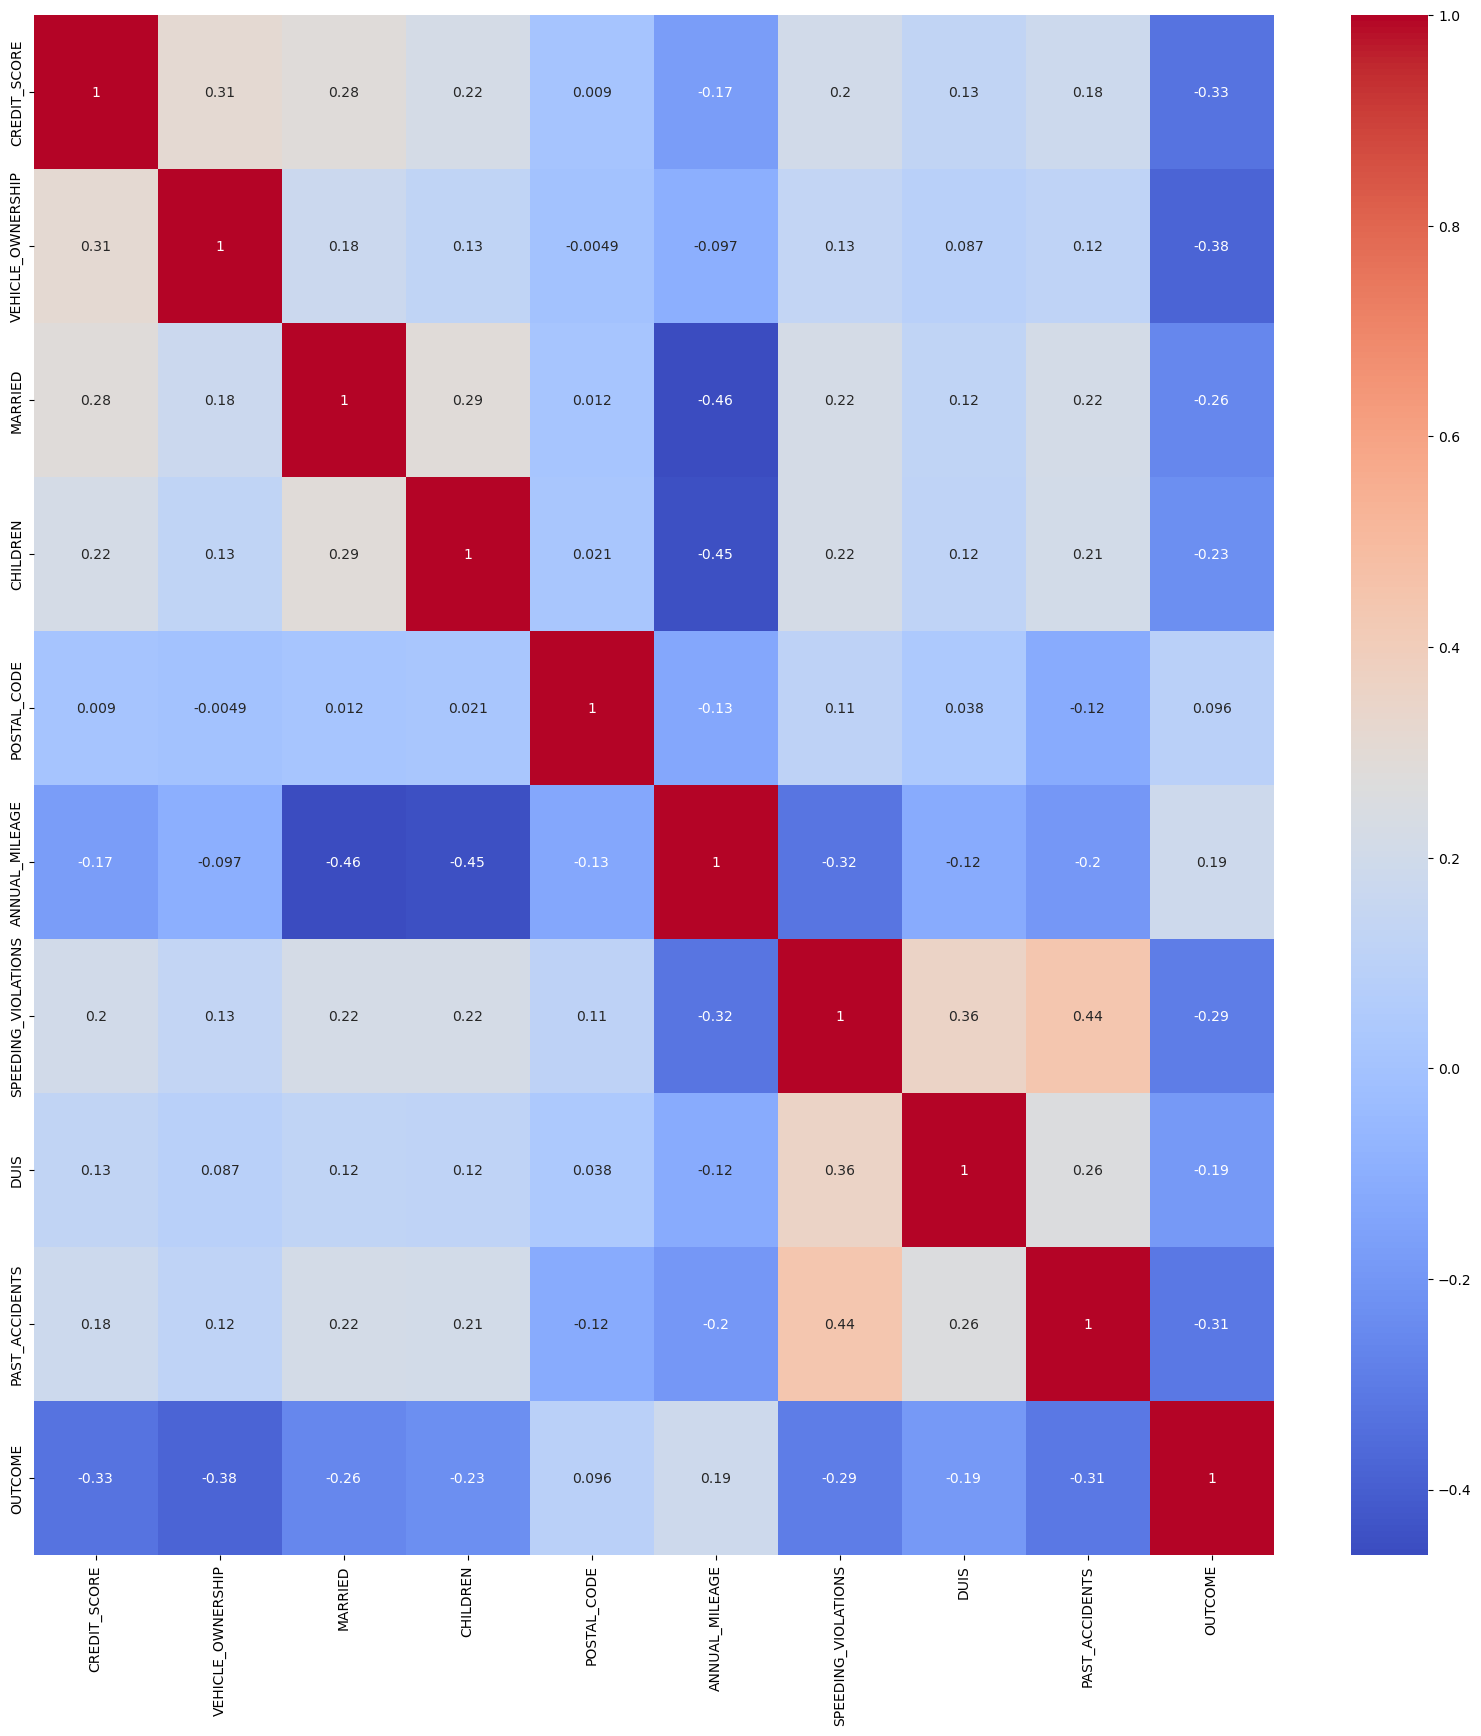

In [9]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(20, 20))
ax = sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

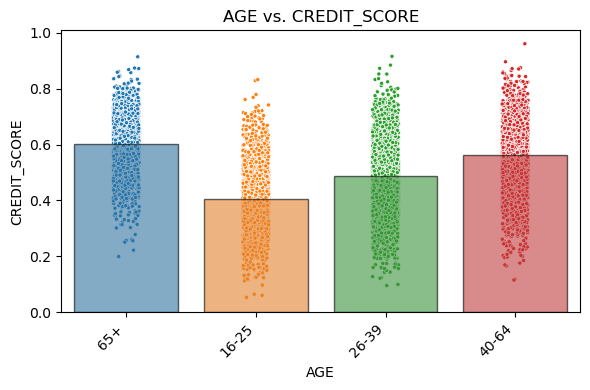

In [10]:
fig, ax = plot_categorical_vs_target(df, x='AGE',y='CREDIT_SCORE')

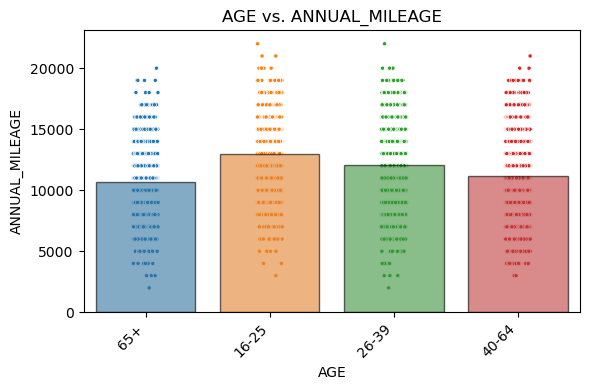

In [11]:
fig, ax = plot_categorical_vs_target(df, x='AGE',y='ANNUAL_MILEAGE')

## Preprocess data


In [12]:
X = df.drop(columns = ['OUTCOME']).copy()
y = df['OUTCOME'].copy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 597605 to 480416
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  7500 non-null   object 
 1   GENDER               7500 non-null   object 
 2   RACE                 7500 non-null   object 
 3   DRIVING_EXPERIENCE   7500 non-null   object 
 4   EDUCATION            7500 non-null   object 
 5   INCOME               7500 non-null   object 
 6   CREDIT_SCORE         6755 non-null   float64
 7   VEHICLE_OWNERSHIP    7500 non-null   float64
 8   VEHICLE_YEAR         7500 non-null   object 
 9   MARRIED              7500 non-null   float64
 10  CHILDREN             7500 non-null   float64
 11  POSTAL_CODE          7500 non-null   int64  
 12  ANNUAL_MILEAGE       6796 non-null   float64
 13  VEHICLE_TYPE         7500 non-null   object 
 14  SPEEDING_VIOLATIONS  7500 non-null   int64  
 15  DUIS                 7500 non-n

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
ID,,,,,,,,,,,,,,,,,
597605,40-64,male,majority,0-9y,high school,upper class,0.694461,1.0,before 2015,1.0,1.0,92101,NaN,sedan,0,0,0
208394,16-25,female,majority,0-9y,none,poverty,0.295794,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,0,0,0
318837,40-64,male,majority,10-19y,university,upper class,NaN,1.0,before 2015,1.0,1.0,10238,NaN,sedan,0,0,3
559214,26-39,female,majority,10-19y,university,working class,0.454836,1.0,before 2015,0.0,0.0,10238,20000.0,sedan,2,0,0
555274,16-25,female,majority,0-9y,none,poverty,0.152972,1.0,before 2015,1.0,0.0,10238,10000.0,sedan,0,0,0


In [14]:
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()

num_pipe = make_pipeline(impute_median, scaler)
num_tuple = ('numeric', num_pipe, num_cols)


Numeric Columns: Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')


In [15]:
ohe_cols =X_train.select_dtypes("object").columns


print("OneHotEncoder Columns:", ohe_cols)

impute_na = SimpleImputer(strategy='most_frequent')

ohe_encoder = OneHotEncoder(drop = 'first', sparse=False)  

ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

OneHotEncoder Columns: Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object')


In [16]:
preprocessor = ColumnTransformer([num_tuple, ohe_tuple], verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [17]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [18]:
X_train_tf = preprocessor.transform(X_train)

X_test_tf = preprocessor.transform(X_test)

X_train_tf.head()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,AGE_26-39,AGE_40-64,AGE_65+,GENDER_male,RACE_minority,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,EDUCATION_none,EDUCATION_university,INCOME_poverty,INCOME_upper class,INCOME_working class,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sports car
ID,,,,,,,,,,,,,,,,,,,,,,,,
597605,1.367938,0.660062,1.000533,0.674880,3.867776,0.098334,-0.659296,-0.432581,-0.643278,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
208394,-1.702804,0.660062,-0.999467,-1.481745,0.694321,0.098334,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
318837,0.063118,0.660062,1.000533,0.674880,-0.510486,0.098334,-0.659296,-0.432581,1.147363,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
559214,-0.477776,0.660062,-0.999467,-1.481745,-0.510486,3.099366,0.229004,-0.432581,-0.643278,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
555274,-2.802891,0.660062,1.000533,-1.481745,-0.510486,-0.651924,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## Modeling: KNN Classification Model

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      5144
         1.0       0.79      0.76      0.77      2356

    accuracy                           0.86      7500
   macro avg       0.84      0.83      0.84      7500
weighted avg       0.86      0.86      0.86      7500



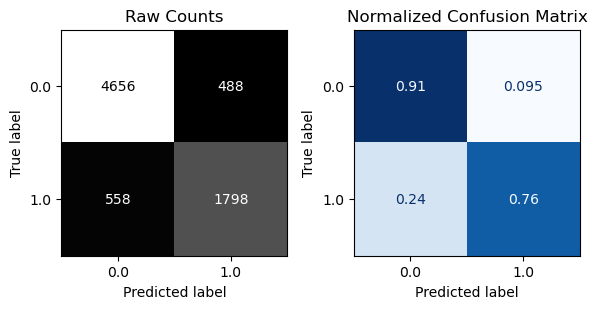


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87      1723
         1.0       0.71      0.69      0.70       777

    accuracy                           0.82      2500
   macro avg       0.79      0.78      0.78      2500
weighted avg       0.81      0.82      0.82      2500



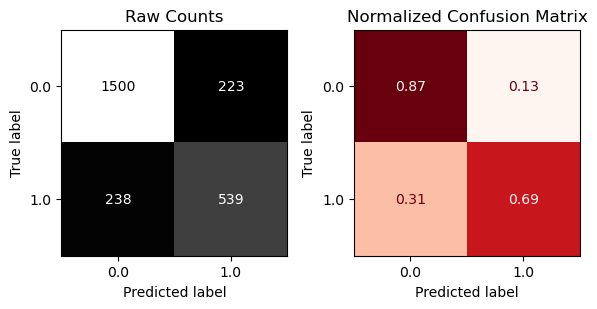

In [19]:
knn = KNeighborsClassifier()

knn_pipe = make_pipeline(preprocessor, knn)

knn_pipe.fit(X_train, y_train)


evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

In [20]:
y.value_counts()

0.0    6867
1.0    3133
Name: OUTCOME, dtype: int64

## We will smote the data because it imbalanced data

In [21]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sampler_pipeline

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88      5144
         1.0       0.69      0.93      0.79      2356

    accuracy                           0.85      7500
   macro avg       0.83      0.87      0.84      7500
weighted avg       0.88      0.85      0.85      7500



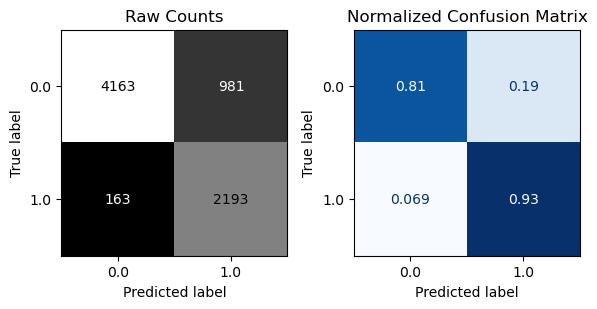


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82      1723
         1.0       0.60      0.82      0.69       777

    accuracy                           0.77      2500
   macro avg       0.75      0.79      0.75      2500
weighted avg       0.81      0.77      0.78      2500



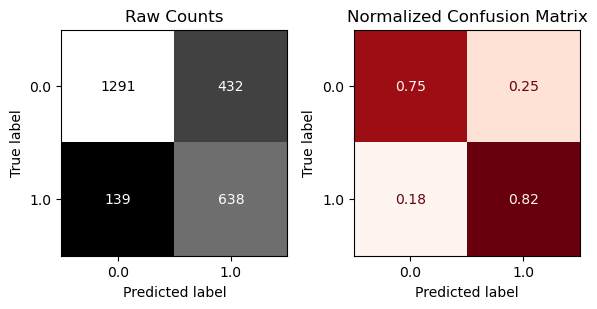

In [22]:
smote = SMOTE(random_state=42)

knn_smote_pipe = make_sampler_pipeline(preprocessor, smote,  knn)

knn_smote_pipe.fit(X_train, y_train)

evaluate_classification(knn_smote_pipe, X_train, y_train, X_test, y_test)

**inspecting results on testing data after verifying that the variance is accepted between training and testing data:**

- an increase in 1 Recall from 69% to 82%
- a decrease of the false positive from 31% to 18%
- Macro avrg for Recall has changed from 78% to 79%

In [23]:
knn_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
          'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
          'PAST_ACCIDENTS'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(drop='first',


## permutation importances

In [24]:
from sklearn.inspection import permutation_importance

In [25]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
                          color_dict=None, ax=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax

In [26]:
permutation_importances = permutation_importance(knn_smote_pipe , X_test, y_test, n_repeats=5, random_state=42)

In [27]:
permutation_importances = pd.Series(permutation_importances['importances_mean'],index=X_test.columns,
                           name = 'permutation importance')

In [28]:
permutation_importances = permutation_importances.sort_values(ascending=False)

permutation_importances

DRIVING_EXPERIENCE     0.04064
VEHICLE_OWNERSHIP      0.03440
SPEEDING_VIOLATIONS    0.02336
AGE                    0.02168
GENDER                 0.01816
VEHICLE_YEAR           0.01768
DUIS                   0.01000
POSTAL_CODE            0.00952
PAST_ACCIDENTS         0.00776
EDUCATION              0.00520
MARRIED                0.00456
CHILDREN               0.00392
ANNUAL_MILEAGE         0.00088
VEHICLE_TYPE           0.00032
CREDIT_SCORE           0.00016
RACE                  -0.00176
INCOME                -0.00192
Name: permutation importance, dtype: float64

<Axes: title={'center': 'Top 10 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

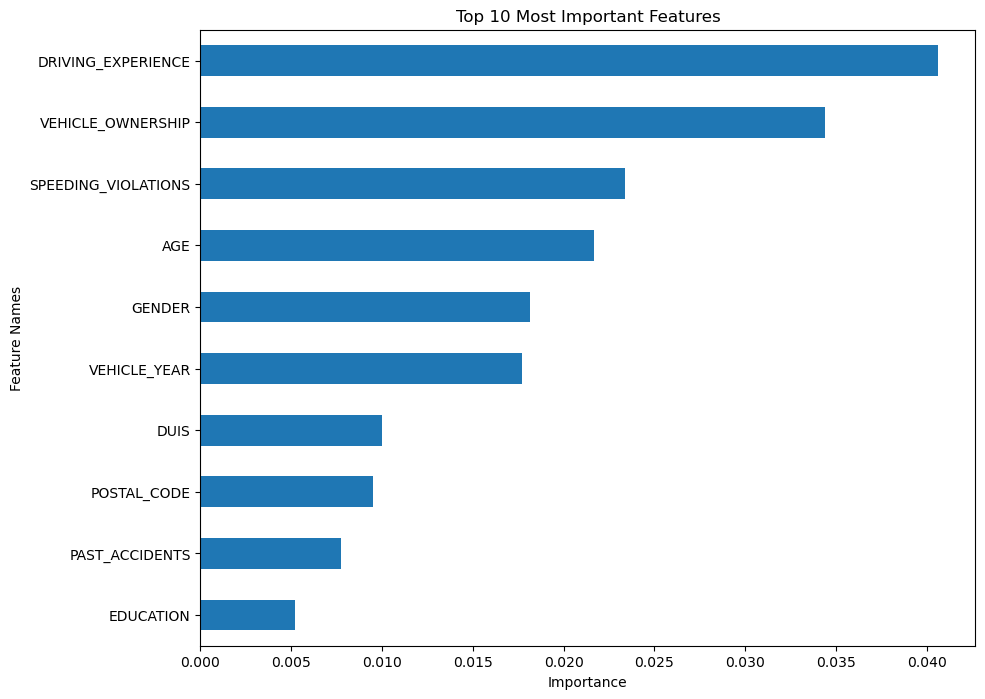

In [29]:
n = 10
plot_importance_color_ax(permutation_importances, top_n=n,
                         figsize=(10,8))

# Visualizing important features for the model we've chosen 

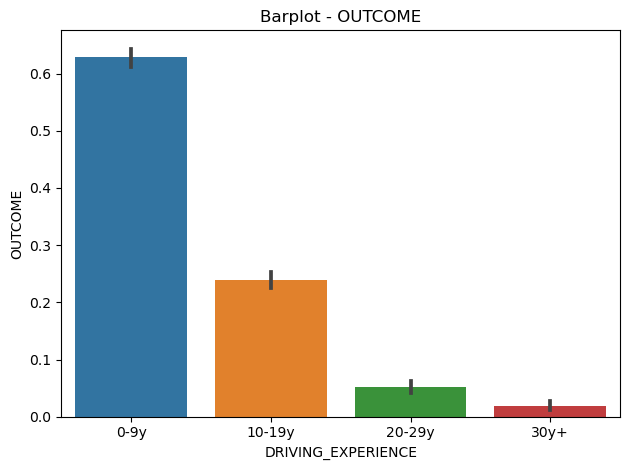

<Figure size 640x480 with 0 Axes>

In [30]:
sns.barplot(data=df, x='DRIVING_EXPERIENCE',y='OUTCOME');


plt.title("Barplot - OUTCOME")
plt.xlabel("DRIVING_EXPERIENCE")
plt.ylabel("OUTCOME")
plt.tight_layout();
plt.show();
plt.savefig('DEvsOUTCOME.png')

- The bar plot can show how different levels of driving experience (such as novice, intermediate, experienced) relate to the outcome of car insurance claims.
- It can help identify if certain levels of driving experience are more prone to accidents or have higher claim outcomes.
- Frequency of Claims Across Driving Experience Categories:

  - The height of the bars can indicate the frequency or count of claims associated with each level of driving experience.
  - You can observe if there are any significant differences in claim frequency based on driving experience.

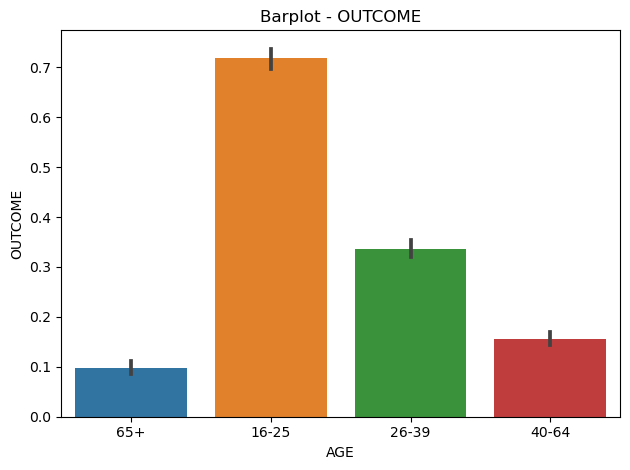

<Figure size 640x480 with 0 Axes>

In [31]:
sns.barplot(data=df, x='AGE',y='OUTCOME');


plt.title("Barplot - OUTCOME")
plt.xlabel("AGE")
plt.ylabel("OUTCOME")
plt.tight_layout();
plt.show();
plt.savefig('AGEvsOUTCOME.png')

- "Considering the distribution of results across different age groups, you can assess whether there are any patterns or trends based on age."
Understanding how claims outcomes differ by age can be crucial for risk assessment and policy pricing.

## Choose two feature engineering

### 1. NonCollinear

In [34]:
y_train.value_counts()

0.0    5144
1.0    2356
Name: OUTCOME, dtype: int64

In [36]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_sm,y_train_sm = smote.fit_resample(X_train_tf, y_train)
y_train_sm.value_counts()

1.0    5144
0.0    5144
Name: OUTCOME, dtype: int64

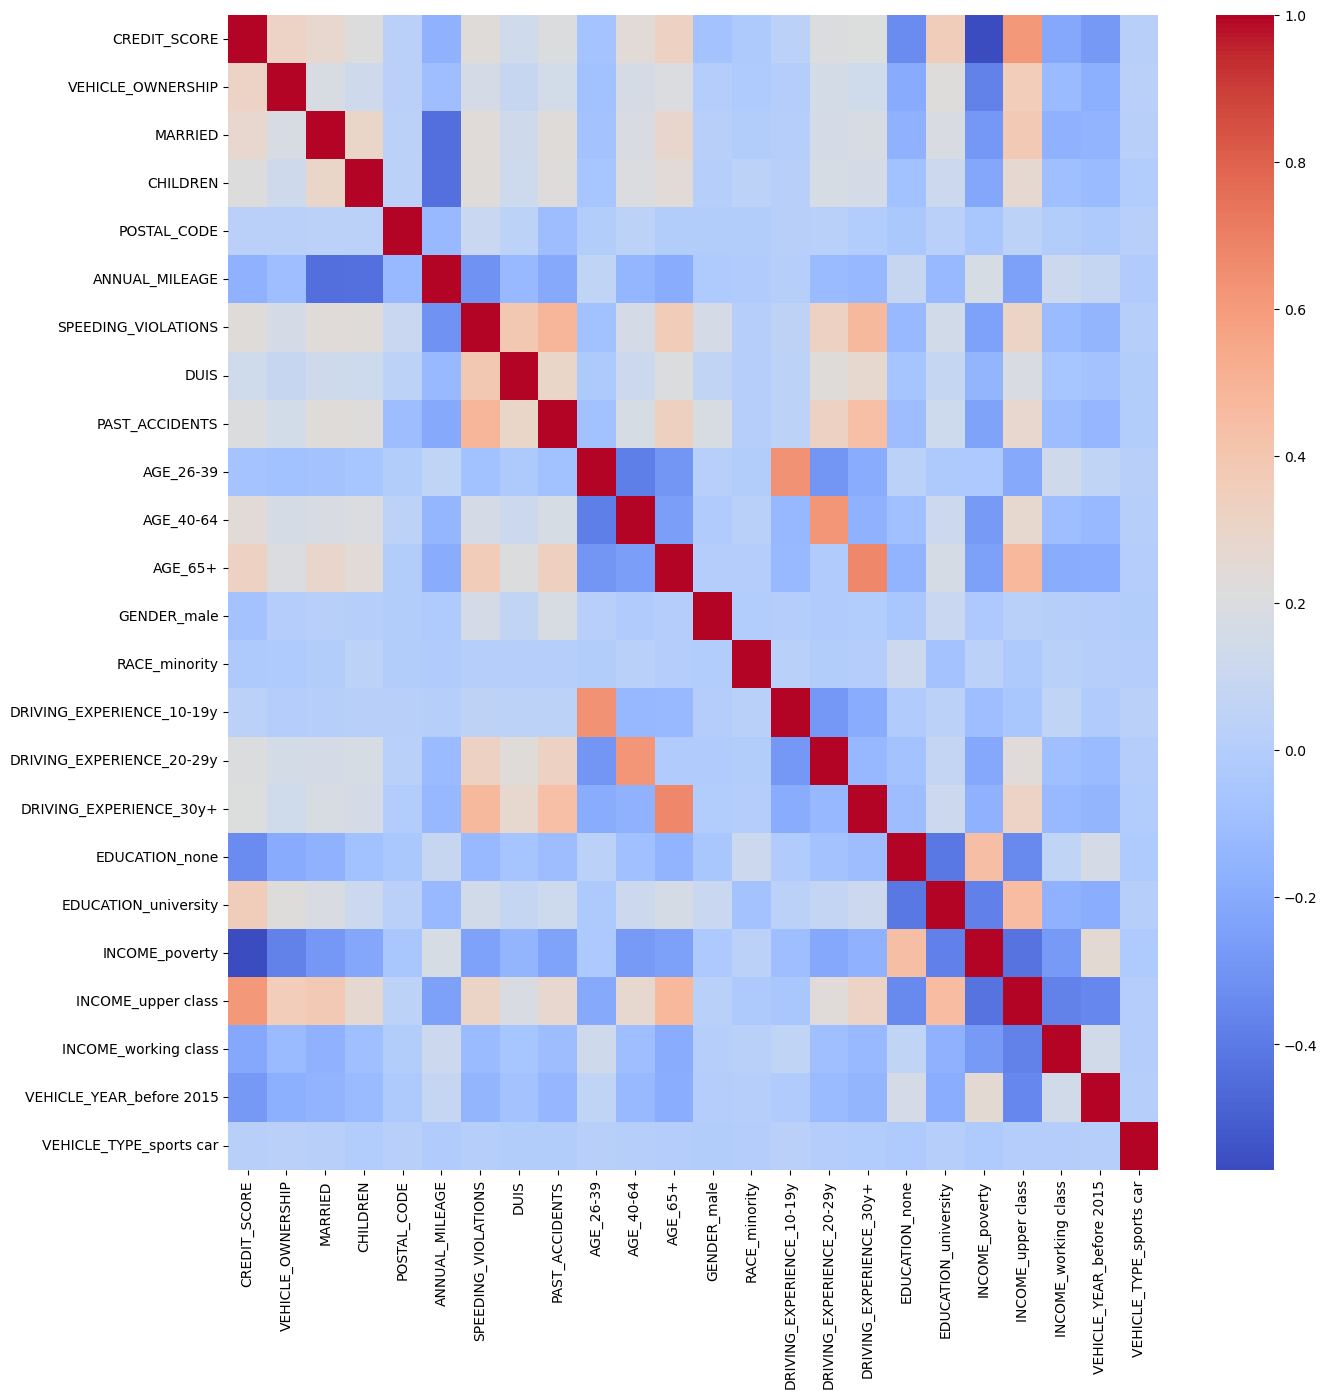

In [37]:
# Make a correlation heatmap of all features
corr = X_train_sm.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm');

In [38]:
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif

In [39]:
selector = SelectNonCollinear(correlation_threshold = 0.75, scoring = f_classif)

In [40]:
selector.fit(X_train_sm.values, y_train_sm.values)

In [41]:
# Define a mask for filtering
non_collinear = selector.get_support()
non_collinear[:5]

[True, True, True, True, True]

In [42]:
# Check how many features are below the theshold
non_collinear.count(True)

24

In [43]:
# Check how many features are above the theshold
non_collinear.count(False)

0

In [44]:
# Make the T/F a series with the column names as the index
non_collinear_series = pd.Series(selector.get_support(), index=X_train_sm.columns)
non_collinear_series

CREDIT_SCORE                 True
VEHICLE_OWNERSHIP            True
MARRIED                      True
CHILDREN                     True
POSTAL_CODE                  True
ANNUAL_MILEAGE               True
SPEEDING_VIOLATIONS          True
DUIS                         True
PAST_ACCIDENTS               True
AGE_26-39                    True
AGE_40-64                    True
AGE_65+                      True
GENDER_male                  True
RACE_minority                True
DRIVING_EXPERIENCE_10-19y    True
DRIVING_EXPERIENCE_20-29y    True
DRIVING_EXPERIENCE_30y+      True
EDUCATION_none               True
EDUCATION_university         True
INCOME_poverty               True
INCOME_upper class           True
INCOME_working class         True
VEHICLE_YEAR_before 2015     True
VEHICLE_TYPE_sports car      True
dtype: bool

In [48]:
# Filter training data
training_data_to_keep = X_train_sm.values[:, non_collinear]
# Filter column names
columns = np.array(X_train_sm.columns)[non_collinear]
# Make traing data into a dataframe
X_train_no_corr = pd.DataFrame(training_data_to_keep, columns = columns)

# Filter testing data
test_data_to_keep = X_test_tf.values[:, non_collinear]
# Make test data into a dataframe
X_test_no_corr = pd.DataFrame(test_data_to_keep, columns = columns)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88      5144
         1.0       0.83      0.96      0.90      5144

    accuracy                           0.89     10288
   macro avg       0.90      0.89      0.89     10288
weighted avg       0.90      0.89      0.89     10288



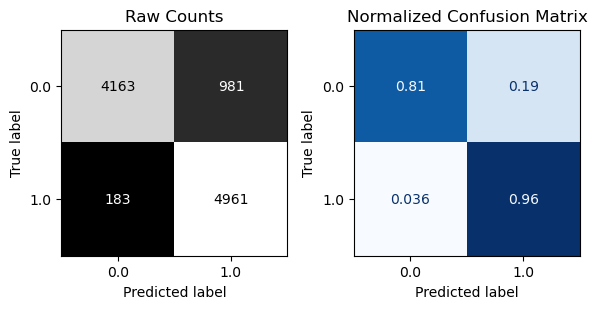


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82      1723
         1.0       0.60      0.82      0.69       777

    accuracy                           0.77      2500
   macro avg       0.75      0.79      0.75      2500
weighted avg       0.81      0.77      0.78      2500



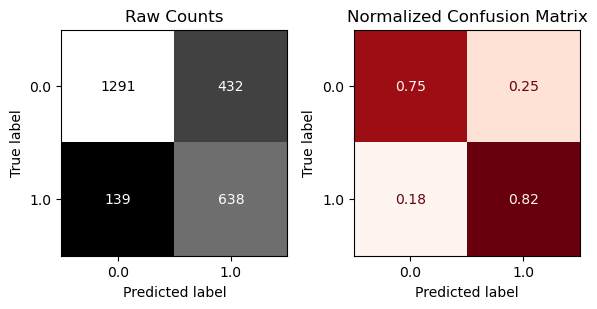

In [52]:
# Test the performance
knn = KNeighborsClassifier()
knn.fit(X_train_no_corr, y_train_sm)
evaluate_classification(knn, X_train_no_corr, y_train_sm, X_test_no_corr, y_test)

### 2. Variance

In [54]:
from sklearn.feature_selection import VarianceThreshold
# checking for constant-features
selector = VarianceThreshold(threshold=0.00)
selector.fit(X_train_tf)

VarianceThreshold()

In [55]:
# get support returns true/false for keeping features
keep_features = selector.get_support()
keep_features[:5]

array([ True,  True,  True,  True,  True])

In [56]:
# Number of features to keep (non-constant features)
keep_features.sum()

24

In [58]:
# checking for quasi-constant-features
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train_tf)

VarianceThreshold(threshold=0.01)

In [59]:
# get support returns true/false for keeping features
keep_features = selector.get_support()
keep_features[:5]

array([ True,  True,  True,  True,  True])

In [60]:
# Number of features to keep (non-quasi-constant features)
keep_features.sum()

24

In [62]:
# Filter based on variance
X_train_var = X_train_tf.loc[:,keep_features]
X_test_var = X_test_tf.loc[:,keep_features]
X_train_var

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,AGE_26-39,AGE_40-64,AGE_65+,GENDER_male,RACE_minority,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,EDUCATION_none,EDUCATION_university,INCOME_poverty,INCOME_upper class,INCOME_working class,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sports car
ID,,,,,,,,,,,,,,,,,,,,,,,,
597605,1.367938,0.660062,1.000533,0.674880,3.867776,0.098334,-0.659296,-0.432581,-0.643278,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
208394,-1.702804,0.660062,-0.999467,-1.481745,0.694321,0.098334,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
318837,0.063118,0.660062,1.000533,0.674880,-0.510486,0.098334,-0.659296,-0.432581,1.147363,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
559214,-0.477776,0.660062,-0.999467,-1.481745,-0.510486,3.099366,0.229004,-0.432581,-0.643278,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
555274,-2.802891,0.660062,1.000533,-1.481745,-0.510486,-0.651924,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897410,1.359188,0.660062,1.000533,0.674880,-0.510486,0.848592,0.673153,1.348077,1.147363,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
674120,0.039220,0.660062,-0.999467,-1.481745,-0.510486,-0.276795,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
295737,0.840692,0.660062,1.000533,0.674880,-0.510486,0.098334,-0.659296,-0.432581,0.550483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [63]:
# Use standardscaler to Scale
scaler = StandardScaler()
scaler.fit(X_train_var)
X_train_var_scaled = scaler.transform(X_train_var)
X_test_var_scaled = standard=scaler.transform(X_test_var)

In [64]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_var_scaled_sm, y_train_sm = smote.fit_resample(X_train_var_scaled, y_train)
y_train_sm.value_counts()

1.0    5144
0.0    5144
Name: OUTCOME, dtype: int64

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89      5144
         1.0       0.85      0.96      0.90      5144

    accuracy                           0.90     10288
   macro avg       0.90      0.90      0.90     10288
weighted avg       0.90      0.90      0.90     10288



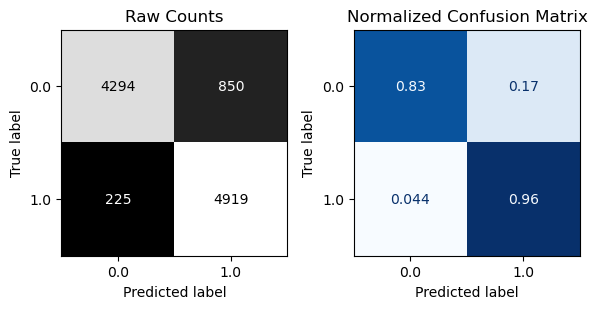


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.78      0.83      1723
         1.0       0.61      0.78      0.69       777

    accuracy                           0.78      2500
   macro avg       0.75      0.78      0.76      2500
weighted avg       0.80      0.78      0.78      2500



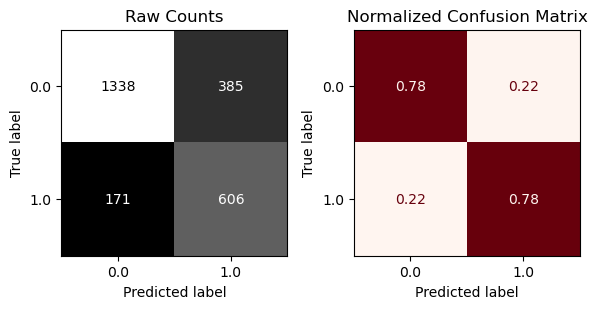

In [65]:
# Test the performance
knn = KNeighborsClassifier()
knn.fit(X_train_var_scaled_sm, y_train_sm)
evaluate_classification(knn, X_train_var_scaled_sm, y_train_sm, X_test_var_scaled, y_test)

## PCA 

In [67]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### Inertia

In [69]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_no_corr)
X_test_pca = pca.transform(X_test_no_corr)

pca.explained_variance_ratio_.sum()

0.952136090365225

Text(0, 0.5, 'inertia')

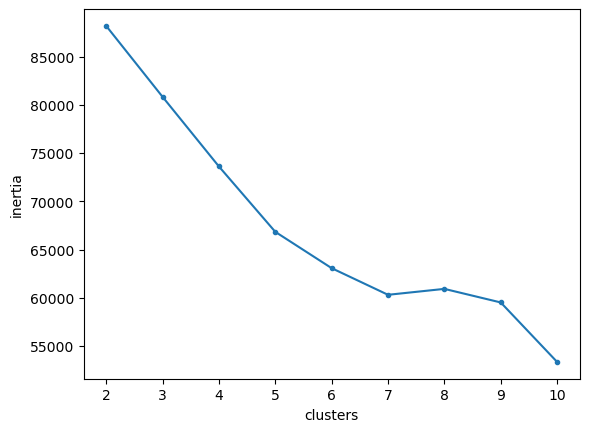

In [72]:
#Create an empty list of inertias
inertias = []
#Loop through k values between 2 and 10 and store the inertias in the list.
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state = 42)  
    kmeans.fit(X_train_pca)  
    inertias.append(kmeans.inertia_)
#Visualize scores
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('clusters')
plt.ylabel('inertia')

## Silhouette Score for KMeans

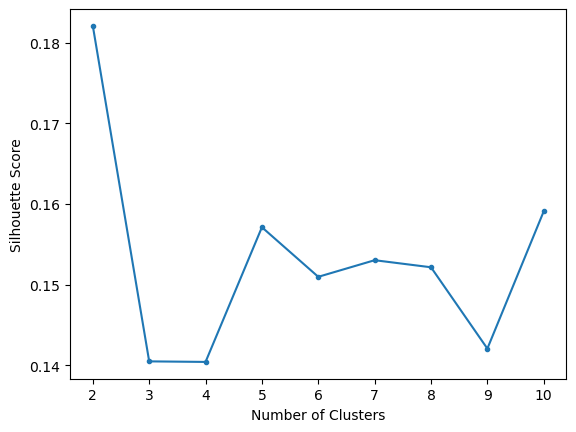

In [75]:
# Visualize different silhouette scores
# Save silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i, n_init = 'auto', random_state = 42)
  kmeans.fit(X_train_pca)
  silhouette_scores.append(silhouette_score(X_train_pca, kmeans.labels_))
# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

In [99]:
# Fit kmeans model with 2 clusters and display the silhouette score
kmeans = KMeans(n_clusters = 2, n_init = 'auto', random_state = 42)
kmeans.fit(X_train_pca)
silhouette_score(X_train_pca, kmeans.labels_)
X_train_pca['cluster'] = kmeans.labels_
X_train_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,cluster
0,1.481374,-0.334398,-3.596891,1.608991,0.551178,-0.414386,-0.106427,-1.305045,-0.415228,-0.350732,0.175323,-0.167060,-0.940788,-0.274126,-0.177824,1
1,-1.889727,0.039105,-0.593864,0.797541,-1.232245,1.193312,-0.103969,0.484174,-0.608309,-0.276242,0.229159,0.723976,0.208343,-0.316331,-0.104575,0
2,1.373711,0.558740,0.117229,-1.059327,-0.223533,0.324015,-0.436745,-1.095460,0.253794,-0.788225,-0.283925,-0.696160,0.149489,-0.431899,-0.438543,1
3,-2.086489,2.453875,0.462677,0.848525,-0.254208,0.018146,-0.040237,-0.818676,1.173732,1.118166,0.284668,-0.375636,0.725563,0.643721,-0.385721,0
4,-1.339157,-0.713714,0.012989,-0.646910,-1.210838,3.023786,0.364393,0.115690,-0.556751,0.023147,0.158733,0.564324,0.432300,-0.235499,-0.052032,0


## Use PCA to define two principal components

In [100]:
pca = PCA()
df_pca = pca.fit_transform(X_train_pca)

In [101]:
print(df_pca.columns)

Index(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15'],
      dtype='object')


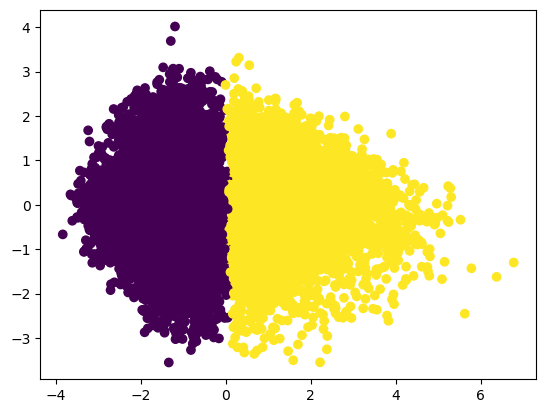

In [102]:
plt.scatter(df_pca['pca0'], df_pca['pca1'], c=kmeans.labels_)

## Fit and evaluate a model using  new features and compare it to your model from Part 1.

### Wrapper Method-Using  Forward Selection

In [83]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier

In [84]:
# Instantiate the model
dt = DecisionTreeClassifier(random_state = 42)

In [86]:
# Instantiate the SequentialFeatureSelector
sk_sfs = SequentialFeatureSelector(dt, n_features_to_select=15,
                                direction = 'forward', cv=2,
                                 n_jobs=-1)
sk_sfs.fit(X_train_no_corr,y_train_sm)

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeClassifier(random_state=42),
                          n_features_to_select=15, n_jobs=-1)

In [87]:
# Preview array of T/F for selected (or not) features
sk_sfs.support_[0:5]

array([False,  True,  True,  True,  True])

In [88]:
# .support_ returns an array of T/F whether it is above threshold
features_to_keep = sk_sfs.support_
# Only include the features selected
X_train_15 = X_train_no_corr.loc[:,features_to_keep]
X_test_15 = X_test_no_corr.loc[:,features_to_keep]
X_train_15.shape

(10288, 15)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86      5144
         1.0       0.86      0.87      0.86      5144

    accuracy                           0.86     10288
   macro avg       0.86      0.86      0.86     10288
weighted avg       0.86      0.86      0.86     10288



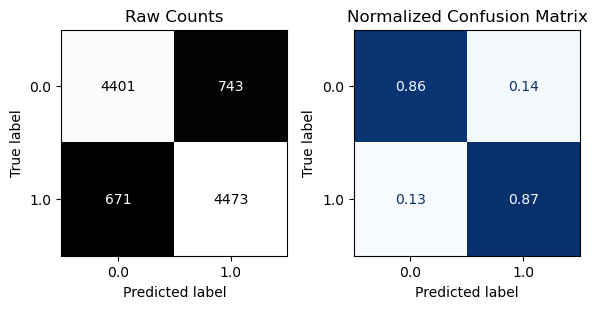


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85      1723
         1.0       0.65      0.75      0.70       777

    accuracy                           0.80      2500
   macro avg       0.76      0.78      0.77      2500
weighted avg       0.81      0.80      0.80      2500



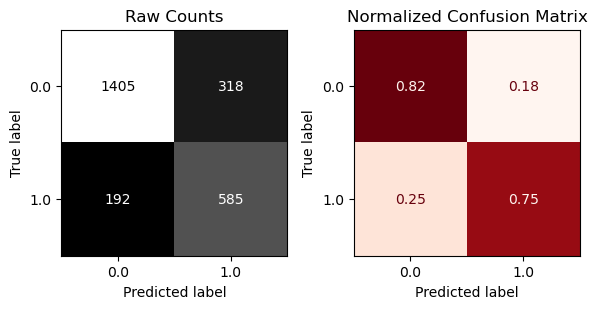

In [89]:
# Instantiate default random forest
knn = KNeighborsClassifier()
# Fit on 15 selected featuers
knn.fit(X_train_15, y_train_sm)
# Evaluate with custom function
evaluate_classification(knn, X_train_15, y_train_sm, X_test_15, y_test)

## New permutation importances

<Axes: title={'center': 'Top 10 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

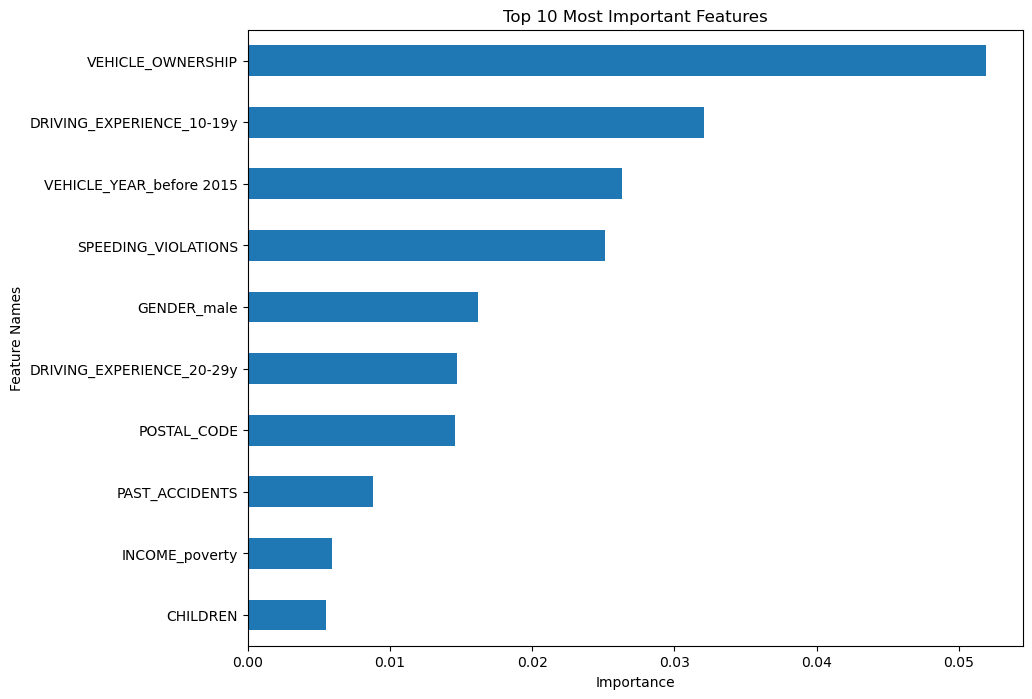

In [96]:
permutation_importances = permutation_importance(knn , X_test_15, y_test, n_repeats=5, random_state=42)
permutation_importances = pd.Series(permutation_importances['importances_mean'],index=X_test_15.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)

permutation_importances
n = 10
plot_importance_color_ax(permutation_importances, top_n=n,
                         figsize=(10,8))